In [17]:
import matplotlib as mpl

current_font_size = mpl.rcParams['font.size']
# mpl.rcParams['font.size'] = current_font_size * 1.5
mpl.rcParams['font.family'] = 'Noto Sans CJK JP'

1.234050878870813e-06


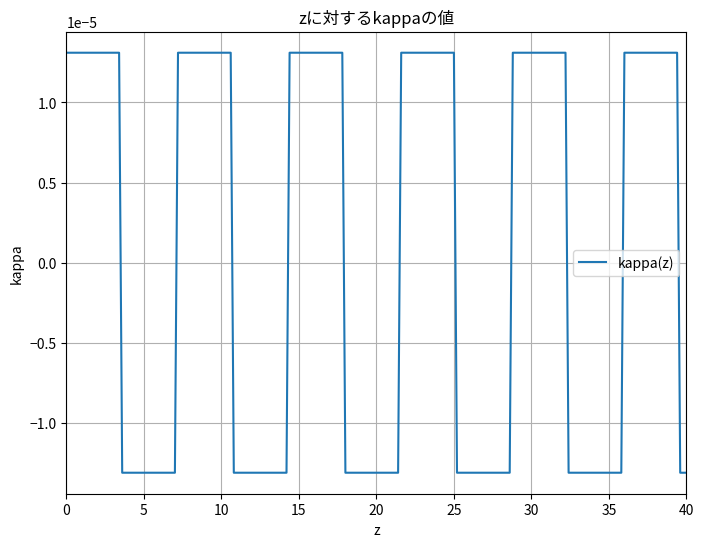

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from syuron import shg2
from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor

T = 70
L = 2000
wavelength = 1.031
A0 = 1.0
B0 = 0.0
Lambda = 7.2

# def kappa(z):
#     if int(z // (Lambda/2)) % 2 == 0:
#         kappa = 1.31E-05
#     else:
#         kappa = -1.31E-05
#     # kappa = 1.31E-05
#     z_kappa_vals.append((z, kappa))
#     return kappa

z_kappa_vals = []

def kappa(z):
    """
    zに依存する正・負領域のペアの間隔を用いて、各領域ごとに
    kappaの符号を決定する関数。
    
    各ペアの総幅（正領域＋負領域）は
        λ = 7.2/(1+0.0001*z_pair)
    と定義され、z_pairはそのペアの開始位置です。
    ペア内では、前半 (幅λ/2) が正、後半 (幅λ/2) が負となります。
    
    引数:
      z (float): 現在の位置
    戻り値:
      float: 計算された kappa の値
    """
    pair_start = 0.0  # 各ペアの開始位置
    while True:
        current_period = 7.2 / (1 + 0.0001 * pair_start)
        half_period = current_period / 2.0

        # 正の領域: [pair_start, pair_start + half_period)
        if z < pair_start + half_period:
            kappa_val = 1.31e-05
            break
        # 負の領域: [pair_start + half_period, pair_start + current_period)
        elif z < pair_start + current_period:
            kappa_val = -1.31e-05
            break
        else:
            # 次のペアへ進む
            pair_start += current_period

    z_kappa_vals.append((z, kappa_val))
    return kappa_val


device = shg2.PPMgOSLT(T)

ncme = shg2.NCME(kappa, device.phase_mismatch(wavelength))
eff = ncme.solve(L, A0, B0)
print(eff)

# Plot z_kappa_vals in a separate plot
z_vals, kappa_vals = zip(*z_kappa_vals)

plt.figure(figsize=(8, 6))
plt.plot(z_vals, kappa_vals, label="kappa(z)")
plt.xlabel("z")
plt.ylabel("kappa")
plt.title("zに対するkappaの値")
plt.grid(True)
plt.xlim(0, L/50)
plt.legend()
plt.show()

Calculating SHG Efficiency: 100%|██████████| 1000/1000 [00:11<00:00, 88.31it/s]



最大効率: 6.964870493515378e-06
最大効率に対応する波長: 1.023162162162162 µm


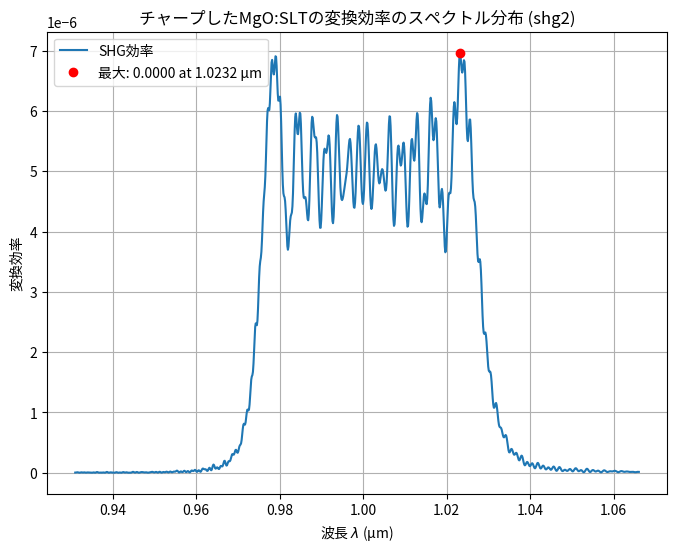

In [19]:
import multiprocessing

lambda_min = wavelength - 0.1
lambda_max = wavelength + 0.035
lambda_values = np.linspace(lambda_min, lambda_max, 1000)

manager = multiprocessing.Manager()


device = shg2.PPMgOSLT(T)


def calc_eff(lam):
    phase_mismatch = device.phase_mismatch(lam)
    ncme = shg2.NCME(kappa, phase_mismatch)
    return ncme.solve(L, A0, B0)


with ProcessPoolExecutor() as executor:
    efficiencies = list(tqdm(
        executor.map(calc_eff, lambda_values),
        total=len(lambda_values),
        desc="Calculating SHG Efficiency"
    ))

plt.figure(figsize=(8, 6))
plt.plot(lambda_values, efficiencies, label="SHG効率")
plt.xlabel(r"波長 $\lambda$ (µm)")
plt.ylabel("変換効率")
plt.title("チャープしたMgO:SLTの変換効率のスペクトル分布 (shg2)")
plt.grid(True)

max_efficiency = max(efficiencies)
max_index = efficiencies.index(max_efficiency)
max_lambda = lambda_values[max_index]

print(f"\n最大効率: {max_efficiency}")
print(f"最大効率に対応する波長: {max_lambda} µm")

plt.plot(max_lambda, max_efficiency, 'ro',
         label=f"最大: {max_efficiency:.4f} at {max_lambda:.4f} µm")
plt.legend()
plt.show()